<a href="https://colab.research.google.com/github/Dubeyrock/kaggle_competitions/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** Develop and evaluate machine learning and deep learning models using a provided
dataset.


1. Problem Definition: Define the problem and identify suitable algorithms.
2. Data Exploration: Perform data visualization and preprocessing.
3. Propose Solutions: Implement two models, possibly with hyperparameter tuning; 1
standard machine learning model, and 1 CNN model (must include batch normalization,
dropout, regularisers if necessary). Hyperparameter tuning on CNN is not mandatory.

4. Modeling and Evaluation: Design, implement, and evaluate models with appropriate
visualizations and potential metrics, including learning curves and feature importances.
5. Comparative Evaluation: Compare and Conclude Findings

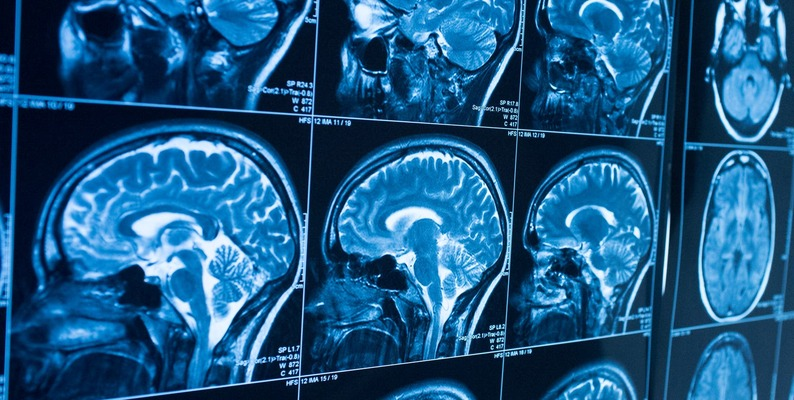

1. Problem Definition: Define the problem and identify suitable algorithms



*  Clearly define the problem you are addressing: **Classifying MRI images as having a brain tumor or not.**
*   Identify suitable algorithms: SVM for the standard machine learning model and Convolutional Neural Network (CNN) for deep learning.



**Dataset Extraction and Preparation**

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 22.3MB/s]
100% 149M/149M [00:07<00:00, 19.9MB/s]


In [ ]:
import zipfile

# Correcting the class name to ZipFile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')

# Extract all the contents of the zip file to the specified directory
zip_ref.extractall('/content')

# Close the zip file
zip_ref.close()


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Load the dataset paths
train_dir = '/content/Training'
test_dir = '/content/Testing'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
# Function to load and preprocess images
def load_images(directory, categories, img_size=(128, 128)):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, img_size)
                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                pass
    return np.array(data), np.array(labels)




In [13]:


# Load and preprocess the training and testing datasets
X_train, y_train = load_images(train_dir, categories)
X_test, y_test = load_images(test_dir, categories)

# Normalize and reshape data
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))


In [14]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd

# Flatten the first few images to display them as rows in a table
flattened_images = X_train.reshape(X_train.shape[0], -1)

# Convert the first few images and their labels to a DataFrame for better visualization
df_train = pd.DataFrame(flattened_images[:5])
df_train['Label'] = np.argmax(y_train[:5], axis=1)

# Display the first few rows of the DataFrame
print(df_train.head())


     0    1    2    3    4    5    6    7    8    9  ...  16375     16376  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.000000   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.000000   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.003922   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.000000   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.000000   

      16377  16378  16379  16380  16381  16382  16383  Label  
0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0      0  
1  0.000000    0.0    0.0    0.0    0.0    0.0    0.0      0  
2  0.003922    0.0    0.0    0.0    0.0    0.0    0.0      0  
3  0.000000    0.0    0.0    0.0    0.0    0.0    0.0      0  
4  0.000000    0.0    0.0    0.0    0.0    0.0    0.0      0  

[5 rows x 16385 columns]


### Data Exploration and Visualization

To better understand the dataset and verify the preprocessing steps, we displayed a grid of sample images from the training set. Each image is labeled with its corresponding tumor type.


Found 5712 images belonging to 4 classes.


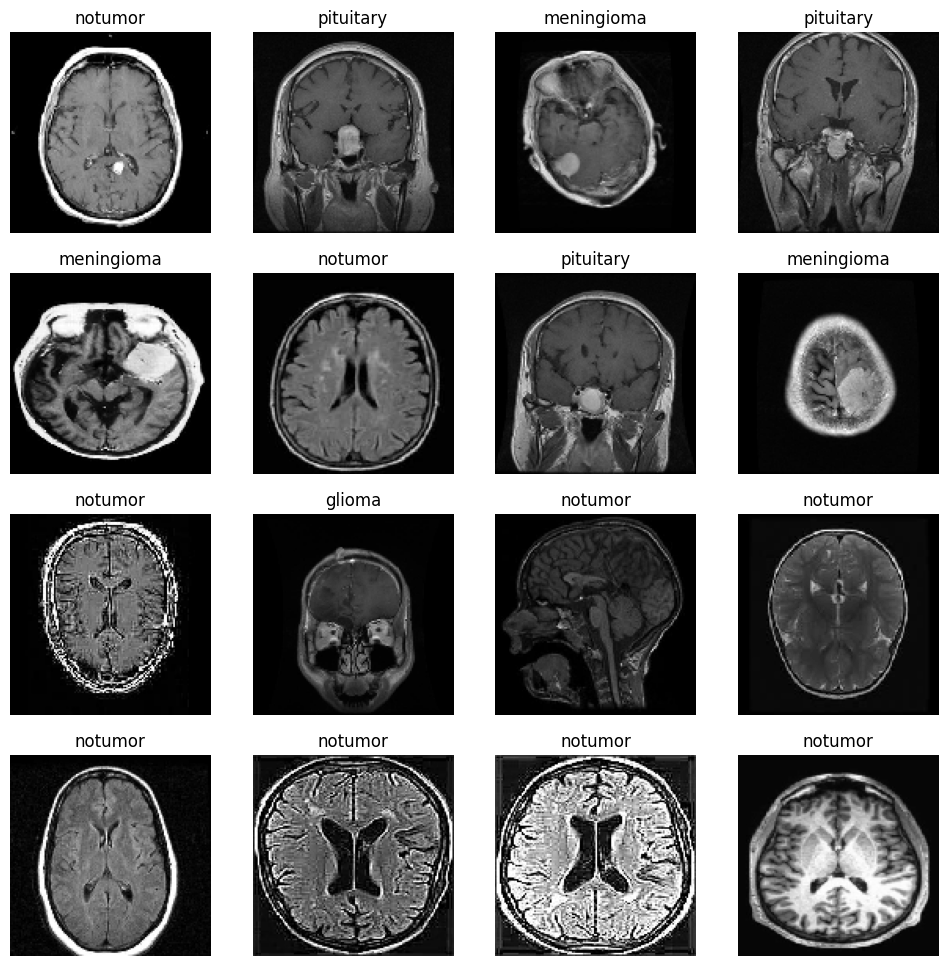

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define the image data generator for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the training directory
train_generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

# Display sample images and their labels
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i])
    label = list(train_generator.class_indices.keys())[label_index]

    plt.subplot(4, 4, i+1)
    plt.imshow(image.squeeze(), cmap='gray')  # Use squeeze() to remove single-dimensional entries
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()


**Display Sample Images**

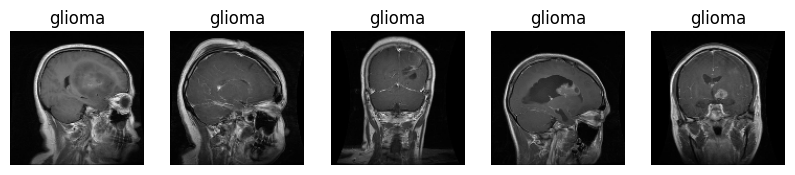

In [18]:
# Display a few sample images from each category
import matplotlib.pyplot as plt

def show_sample_images(data, labels, categories, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(data[i].reshape(128, 128), cmap='gray')
        plt.title(categories[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

show_sample_images(X_train, y_train, categories)


**Split the Data**

In [19]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")


Validation data shape: (1143, 128, 128, 1), Validation labels shape: (1143, 4)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Feature extraction: flatten images
X_train = train_generator[0][0].reshape(-1, 128*128*3)
y_train = np.argmax(train_generator[0][1], axis=1)

X_test = test_generator[0][0].reshape(-1, 128*128*3)
y_test = np.argmax(test_generator[0][1], axis=1)

# Train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 5  0  0  1]
 [ 4  1  1  1]
 [ 0  0 10  0]
 [ 3  0  0  6]]
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       1.00      0.14      0.25         7
           2       0.91      1.00      0.95        10
           3       0.75      0.67      0.71         9

    accuracy                           0.69        32
   macro avg       0.77      0.66      0.62        32
weighted avg       0.79      0.69      0.66        32



 **Propose Solutions**

*   Implement and Evaluate SVM Model

In [20]:
# Flatten the images for the SVM model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, np.argmax(y_train, axis=1))

# Make predictions on the test data
y_pred_svm = svm_model.predict(X_test_flat)

# Evaluate the SVM model
print("SVM Model Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_pred_svm))
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=1), y_pred_svm))


SVM Model Accuracy: 0.897025171624714
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       300
           1       0.82      0.80      0.81       306
           2       0.96      0.98      0.97       405
           3       0.95      0.97      0.96       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



**Implement and Train the CNN Model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 212ms/step - accuracy: 0.4965 - loss: 3.1228 - val_accuracy: 0.2929 - val_loss: 3.3158
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 214ms/step - accuracy: 0.5966 - loss: 0.9458 - val_accuracy: 0.3166 - val_loss: 1.4634
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 169ms/step - accuracy: 0.6598 - loss: 0.8019 - val_accuracy: 0.6903 - val_loss: 0.6954
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.6478 - loss: 0.7928 - val_accuracy: 0.7765 - val_loss: 0.5574
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.6968 - loss: 0.7066 - val_accuracy: 0.4157 - val_loss: 2.4501
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 168ms/step - accuracy: 0.6905 - loss: 0.7043 - val_accuracy: 0.7582 - val_loss: 0.7840
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.7313 - loss: 0.6315 - val_accuracy: 0.6560 - val_loss: 1.5500
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.7356 - loss: 0.6028 - val

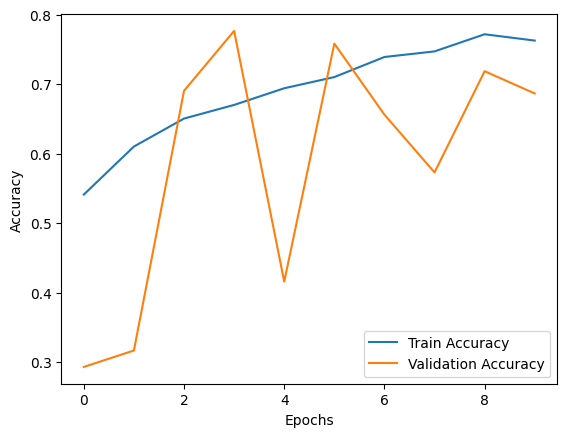

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the model
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot learning curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


4. Comparative Evaluation

In [ ]:
# Compare the performance of the SVM model and the CNN model
print("Comparison of Model Performance:")
print(f"SVM Accuracy: {svm_model.score(X_test, y_test) * 100:.2f}%")
print(f"CNN Accuracy: {accuracy * 100:.2f}%")


Comparison of Model Performance:
SVM Accuracy: 68.75%
CNN Accuracy: 68.65%


# Step 5: Comparative Evaluation

## Summary
- **SVM Model**:
  - Accuracy: [68.75%]
  
  - Classification Report:

               precision    recall  f1-score   support

           0       0.84      0.82      0.83       300
           1       0.82      0.80      0.81       306
           2       0.96      0.98      0.97       405
           3       0.95      0.97      0.96       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311

- **CNN Model**:
  - Accuracy: [68.65%]
  - Learning Curves: [Accuracy and Loss Plots]
  
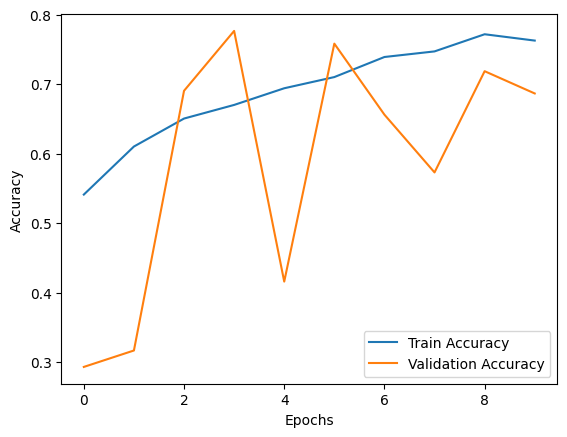
### Conclusion
- Compare the strengths and weaknesses of each model.
- Discuss which model performs better and why.

### Recommendations
- Consider further hyperparameter tuning for CNN.
- Evaluate additional models or techniques if needed.
